<a href="https://colab.research.google.com/github/shrestha-bikash/Facemask-Detection/blob/main/Facemask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! tar -xf facemask_detection.tar.xz

In [ ]:
import os

data_path = 'facemask/'

def get_file_lists(path, listing_name):
    fw = open(listing_name, 'w')

    for dirpath, dirname, filenames in os.walk(path):
        
        print(dirpath)
        # dir_name = dirpath.split('/')[-1]
        # print(dir_name)

        for f_name in filenames:
            file_path = dirpath + '/' + f_name
            fw.write(file_path + '\n')
            
    fw.close()

train_path = data_path + 'Train'
test_path = data_path + 'Test'
validation_path = data_path + 'Validation'

get_file_lists(train_path, 'training_list.txt')
get_file_lists(test_path, 'test_list.txt')
get_file_lists(validation_path, 'validation_list.txt')

facemask/Train
facemask/Train/Non-Mask
facemask/Train/Mask
facemask/Test
facemask/Test/Non-Mask
facemask/Test/Mask
facemask/Validation
facemask/Validation/Non-Mask
facemask/Validation/Mask


In [ ]:
! cat test_list.txt

In [ ]:
from PIL import Image
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.efficientnet import preprocess_input

def get_list(path):
    f = open(path, 'r')
    flines = f.readlines()
    f.close()

    file_list = []

    for line in flines:
        file_name = line.split()[0]
        file_list.append(file_name)
    
    return file_list

def load_and_resize_image(path):
    img = load_img(path, target_size=(224, 224))
    img = np.array(img)
    img = preprocess_input(img)

    return img

def one_hot_encoding(class_labels, y_label):
    y_class = np.zeros(len(class_labels), dtype=int)
    class_index = class_labels.index(y_label)

    y_class[class_index] = 1

    return y_class

def get_input_output(path, batch_list, class_labels):
    X = np.zeros((len(batch_list), 224, 224, 3))
    Y = np.zeros((len(batch_list), 1))

    for index, item in enumerate(batch_list):
        x = load_and_resize_image(item)
        
        label = item.split('/')[-2]
        if label == 'Mask':
            y = 1
        elif label == 'Non-Mask':
            y = 0
        else:
            y = -1

        # x = np.expand_dims(img_data, axis=-1)

        X[index, :, :, :] = x
        Y[index] = y
    
    return X, Y

(224, 224, 3)


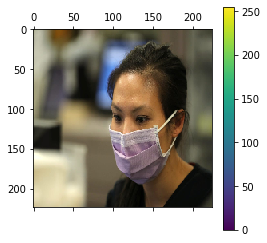

In [ ]:
import matplotlib.pyplot as plt

img_np = load_and_resize_image('facemask/Train/Mask/0972.jpg')

print(img_np.shape)


plt.matshow(img_np)
plt.colorbar()
plt.show()

In [ ]:
from tensorflow.keras.utils import  Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, data_path, image_list, class_labels, batch_size):
        self.data_path = data_path
        self.image_list = image_list
        self.batch_size = batch_size
        self.class_labels = class_labels

    def __len__(self):
        return int(len(self.image_list) / self.batch_size)

    def __getitem__(self, index):
        batch_list = self.image_list[index * self.batch_size : (index + 1) * self.batch_size]

        X, Y = get_input_output(self.data_path, batch_list, class_labels)

        return X, Y

In [ ]:
class_labels = ['Mask', 'Non-Mask']

training_list_path = 'training_list.txt'
validation_list_path = 'validation_list.txt'
test_list_path = 'test_list.txt'

training_list = get_list(training_list_path)
validation_list = get_list(validation_list_path)
np.random.shuffle(training_list)
np.random.shuffle(validation_list)

testing_list = get_list(test_list_path)

print('length of training dataset:', len(training_list))
print('length of validation dataset:', len(validation_list))
print('length of test dataset:', len(testing_list))

length of training dataset: 600
length of validation dataset: 306
length of test dataset: 100


In [ ]:
batch_size = 32

train_generator = ImageDataGenerator(data_path, training_list, class_labels, batch_size)
validation_generator = ImageDataGenerator(data_path, validation_list, class_labels, batch_size)

print(len(train_generator))
print(len(validation_generator))

xx, yy = train_generator[0]

print(xx.shape)
print(yy)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4

def conv_model(input_shape):
    model = Sequential()
    model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape = input_shape ) )
    model.add( BatchNormalization())
    model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' ))
    model.add( MaxPool2D() )
    model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
    model.add( BatchNormalization())
    model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
    model.add( MaxPool2D() )
    model.add( BatchNormalization())
    model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
    model.add( MaxPool2D() )
    model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu' ) )

    model.add( Flatten() )
    model.add( Dense( 10, activation = 'relu' ) )
    model.add( Dense( 2, activation = 'softmax' ) )

    return model

def efficientNet(input_shape):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )

    # for layer in base_model.layers:
    #     layer.trainable = False

    model = Sequential()
   
    model.add(base_model)
    # model.add( MaxPool2D() )

    model.add( Flatten() )
    # model.add(BatchNormalization())
    model.add( Dense( 32, activation = 'relu' ) )
    model.add(BatchNormalization())
    model.add( Dense( 10, activation = 'relu' ) )
    model.add(Dropout(0.3))

    model.add( Dense( 2, activation = 'softmax' ) )

    return model

In [ ]:
# model = conv_model((64, 64, 3))
model = efficientNet((224, 224, 3))
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_11 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2007072   
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)               

In [ ]:
epochs = 16
file_weights = 'model_weights.hdf5'

history = model.fit(train_generator,
    validation_data = validation_generator,
    callbacks = [ModelCheckpoint(filepath = file_weights, monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1)],
    verbose = 1,
    epochs = epochs)

Epoch 1/16
18/18 [==============================] - 17s 922ms/step - loss: 0.0514 - accuracy: 0.7691 - val_loss: 0.0378 - val_accuracy: 0.9896

Epoch 00001: val_loss improved from inf to 0.03784, saving model to model_weights.hdf5
Epoch 2/16
18/18 [==============================] - 16s 878ms/step - loss: 0.0397 - accuracy: 0.7344 - val_loss: 0.0467 - val_accuracy: 0.9549

Epoch 00002: val_loss did not improve from 0.03784
Epoch 3/16
18/18 [==============================] - 16s 880ms/step - loss: 0.0371 - accuracy: 0.7830 - val_loss: 0.0464 - val_accuracy: 0.9722

Epoch 00003: val_loss did not improve from 0.03784
Epoch 4/16
18/18 [==============================] - 16s 883ms/step - loss: 0.0281 - accuracy: 0.7691 - val_loss: 0.0443 - val_accuracy: 0.9826

Epoch 00004: val_loss did not improve from 0.03784
Epoch 5/16
18/18 [==============================] - 16s 879ms/step - loss: 0.0270 - accuracy: 0.8021 - val_loss: 0.0438 - val_accuracy: 0.9722

Epoch 00005: val_loss did not improve fr


Curves..


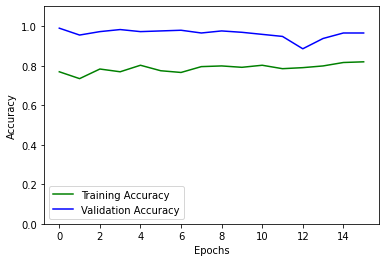

In [ ]:
def plot_learning_curves(history):
    print('')
    print('Curves..')
    # print(history.params)
    plt.clf()
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], 'g', label = 'Training Accuracy')
        plt.plot(history.history['val_accuracy'], 'b', label = 'Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    else:
        plt.plot(history.history['mae'], 'g', label = 'Training MAE')
        plt.plot(history.history['val_mae'], 'b', label = 'Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
    
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()

plot_learning_curves(history)

In [ ]:
test_generator = ImageDataGenerator(data_path, testing_list, class_labels, batch_size)
print('Test generator size:', len(test_generator))

Test generator size: 3


In [ ]:
model.load_weights(file_weights)
score, acc = model.evaluate(test_generator)

3/3 [==============================] - 2s 492ms/step - loss: 6.6462e-04 - accuracy: 0.8646


In [ ]:
y_test = []

for i in range(len(test_generator)):
    xx, yy = test_generator[i]
    for j in range(batch_size):
        class_label = yy[j]
        y_test.append(class_label)